In [1]:
import pandas as pd
import numpy as np
import os
from env import get_db_url
from pathlib import Path 
import csv
import wrangle as w
from scipy import stats

# modeling methods
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression, LassoLars, TweedieRegressor
from sklearn.preprocessing import PolynomialFeatures
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
import sklearn.preprocessing

import warnings
warnings.filterwarnings("ignore")

from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler, QuantileTransformer

# Prepare

* Removed null values stored as whitespace
* Changed total charges from object to float and did not identify or address outliers
* Split data into train, validate and test(approx. 74/16/10)
* Encoded binary categorical variables to 1 or 0 
* Converted non-binary categorical variables to 1 and 0 
* No columns were dropped during preparation 

## Data Dictionary
| Feature | Definition |
|:--------|:-----------|
|Beds| Number of bedrooms in the home|
|Baths| Number of bathrooms in the home|
|sqft| The square footage of the home|
|room count| Represents the total number of rooms in the home|
|fips| The county the property is located in Los Angelese County CA, Ventura CA or Orange County CA|

In [2]:
# creating train, validate and test datasets
train, validate, test = w.wrangle_zillow()

In [3]:
#size of train dataset
train.shape

(25950, 65)

In [4]:
#size of train validate dataset
validate.shape

(11122, 65)

In [5]:
#size of Test dataset
test.shape

(9268, 65)

In [6]:
#Null count in train dataset
train.isnull().sum()

propertylandusetypeid             0
parcelid                          0
id                                0
logerror                          0
transactiondate                   0
id.1                              0
airconditioningtypeid         19835
architecturalstyletypeid      25913
basementsqft                  25932
baths                             0
beds                              0
buildingclasstypeid           25950
buildingqualitytypeid          8844
calculatedbathnbr                39
decktypeid                    25815
finishedfloor1squarefeet      23830
sqft                              0
finishedsquarefeet12             93
finishedsquarefeet13          25950
finishedsquarefeet15          25950
finishedsquarefeet50          23830
finishedsquarefeet6           25857
fips                              0
fireplacecnt                  22494
fullbathcnt                      39
garagecarcnt                  17390
garagetotalsqft               17390
hashottuborspa              

In [7]:
#Null count in validate dataset
validate.isnull().sum()

propertylandusetypeid             0
parcelid                          0
id                                0
logerror                          0
transactiondate                   0
id.1                              0
airconditioningtypeid          8503
architecturalstyletypeid      11106
basementsqft                  11114
baths                             0
beds                              0
buildingclasstypeid           11122
buildingqualitytypeid          3785
calculatedbathnbr                 6
decktypeid                    11065
finishedfloor1squarefeet      10224
sqft                              0
finishedsquarefeet12             38
finishedsquarefeet13          11122
finishedsquarefeet15          11122
finishedsquarefeet50          10224
finishedsquarefeet6           11084
fips                              0
fireplacecnt                   9571
fullbathcnt                       6
garagecarcnt                   7466
garagetotalsqft                7466
hashottuborspa              

In [8]:
#Null count in test dataset
test.isnull().sum()

propertylandusetypeid            0
parcelid                         0
id                               0
logerror                         0
transactiondate                  0
id.1                             0
airconditioningtypeid         7063
architecturalstyletypeid      9251
basementsqft                  9259
baths                            0
beds                             0
buildingclasstypeid           9268
buildingqualitytypeid         3136
calculatedbathnbr                9
decktypeid                    9229
finishedfloor1squarefeet      8558
sqft                             0
finishedsquarefeet12            26
finishedsquarefeet13          9268
finishedsquarefeet15          9268
finishedsquarefeet50          8558
finishedsquarefeet6           9242
fips                             0
fireplacecnt                  8017
fullbathcnt                      9
garagecarcnt                  6229
garagetotalsqft               6229
hashottuborspa                9140
heatingorsystemtypei

In [9]:
test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9268 entries, 7505 to 29889
Data columns (total 65 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   propertylandusetypeid       9268 non-null   float64
 1   parcelid                    9268 non-null   int64  
 2   id                          9268 non-null   int64  
 3   logerror                    9268 non-null   float64
 4   transactiondate             9268 non-null   object 
 5   id.1                        9268 non-null   int64  
 6   airconditioningtypeid       2205 non-null   float64
 7   architecturalstyletypeid    17 non-null     float64
 8   basementsqft                9 non-null      float64
 9   baths                       9268 non-null   float64
 10  beds                        9268 non-null   float64
 11  buildingclasstypeid         0 non-null      float64
 12  buildingqualitytypeid       6132 non-null   float64
 13  calculatedbathnbr           9

In [10]:
# columns used as independent variables 
x_cols = ['baths','sqft','beds']

In [11]:
# assigning values to x/y train, validate and test 
X_train = train[x_cols]
y_train = train['property_value']

X_validate = validate[x_cols]
y_validate = validate['property_value']

X_test = test[x_cols]
y_test = test['property_value']


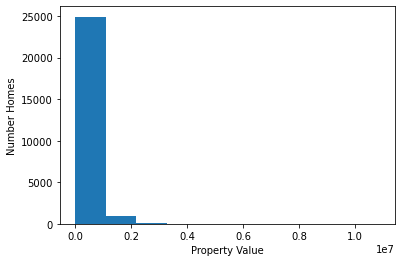

In [12]:
# Visualizing target variable "Property Value"
plt.hist(y_train)
plt.xlabel("Property Value")
plt.ylabel("Number Homes")
plt.show()


## Baseline 

In [13]:
# We need y_train and y_validate to be dataframes to append the new columns with predicted values. 
y_train = pd.DataFrame(y_train)
y_validate = pd.DataFrame(y_validate)

# 1. Predict property_value_pred_mean
prop_value_pred_mean = y_train['property_value'].mean()
y_train['prop_value_pred_mean'] = prop_value_pred_mean
y_validate['prop_value_pred_mean'] = prop_value_pred_mean

# 2. compute prop_value_pred_median
prop_value_pred_median = y_train['property_value'].median()
y_train['prop_value_pred_median'] = prop_value_pred_median
y_validate['prop_value_pred_median'] = prop_value_pred_median

# 3. RMSE of prop_value_pred_mean
rmse_train = mean_squared_error(y_train.property_value, y_train.prop_value_pred_mean)**(1/2)
rmse_validate = mean_squared_error(y_validate.property_value, y_validate.prop_value_pred_mean)**(1/2)

print("RMSE using Mean\nTrain/In-Sample: ", round(rmse_train, 2), 
      "\nValidate/Out-of-Sample: ", round(rmse_validate, 2))

# 4. RMSE of prop_value_pred_median
rmse_train = mean_squared_error(y_train.property_value, y_train.prop_value_pred_median)**(1/2)
rmse_validate = mean_squared_error(y_validate.property_value, y_validate.prop_value_pred_median)**(1/2)

print("RMSE using Median\nTrain/In-Sample: ", round(rmse_train, 2), 
      "\nValidate/Out-of-Sample: ", round(rmse_validate, 2))


RMSE using Mean
Train/In-Sample:  374068.55 
Validate/Out-of-Sample:  387413.56
RMSE using Median
Train/In-Sample:  380783.0 
Validate/Out-of-Sample:  395096.96


## Visualizing target variable 

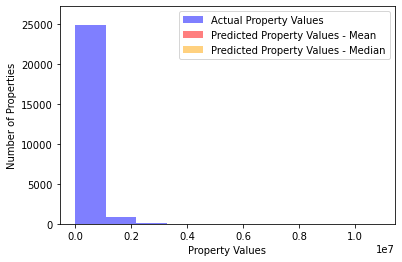

In [14]:
# plot to visualize actual vs predicted. 
plt.hist(y_train.property_value, color='blue', alpha=.5, label="Actual Property Values")
plt.hist(y_train.prop_value_pred_mean, bins=1, color='red', alpha=.5, rwidth=20, label="Predicted Property Values - Mean")
plt.hist(y_train.prop_value_pred_median, bins=1, color='orange', alpha=.5, rwidth=20, label="Predicted Property Values - Median")
plt.xlabel("Property Values")
plt.ylabel("Number of Properties")
plt.legend()
plt.show()


## LinearRegression OLS

In [15]:
# create the model object
lm = LinearRegression(normalize=True)

# fit the model to our training data. We must specify the column in y_train, 
# since we have converted it to a dataframe from a series! 
lm.fit(X_train, y_train.property_value)

# predict train
y_train['property_value_pred_lm'] = lm.predict(X_train)

# evaluate: rmse
rmse_train = mean_squared_error(y_train.property_value, y_train.property_value_pred_lm)**(1/2)

# predict validate
y_validate['property_value_pred_lm'] = lm.predict(X_validate)

# evaluate: rmse
rmse_validate = mean_squared_error(y_validate.property_value, y_validate.property_value_pred_lm)**(1/2)

print("RMSE for OLS using LinearRegression\nTraining/In-Sample: ", rmse_train, 
      "\nValidation/Out-of-Sample: ", rmse_validate)


RMSE for OLS using LinearRegression
Training/In-Sample:  344065.8617743427 
Validation/Out-of-Sample:  356369.3872642391


## LassoLars

In [16]:
# create the model object
lars = LassoLars(alpha=1.0)

# fit the model to our training data. We must specify the column in y_train, 
# since we have converted it to a dataframe from a series! 
lars.fit(X_train, y_train.property_value)

# predict train
y_train['property_value_pred_lars'] = lars.predict(X_train)

# evaluate: rmse
rmse_train = mean_squared_error(y_train.property_value, y_train.property_value_pred_lars)**(1/2)

# predict validate
y_validate['property_value_pred_lars'] = lars.predict(X_validate)

# evaluate: rmse
rmse_validate = mean_squared_error(y_validate.property_value, y_validate.property_value_pred_lars)**(1/2)

print("RMSE for Lasso + Lars\nTraining/In-Sample: ", rmse_train, 
      "\nValidation/Out-of-Sample: ", rmse_validate)


RMSE for Lasso + Lars
Training/In-Sample:  344066.0761344583 
Validation/Out-of-Sample:  356372.14646836766


## TweedieRegressor(GLM)

In [17]:
# create the model object
glm = TweedieRegressor(power=1, alpha=0)

# fit the model to our training data. We must specify the column in y_train, 
# since we have converted it to a dataframe from a series! 
glm.fit(X_train, y_train.property_value)

# predict train
y_train['property_value_pred_glm'] = glm.predict(X_train)

# evaluate: rmse
rmse_train = mean_squared_error(y_train.property_value, y_train.property_value_pred_glm)**(1/2)

# predict validate
y_validate['property_value_pred_glm'] = glm.predict(X_validate)

# evaluate: rmse
rmse_validate = mean_squared_error(y_validate.property_value, y_validate.property_value_pred_glm)**(1/2)

print("RMSE for GLM using Tweedie, power=1 & alpha=0\nTraining/In-Sample: ", rmse_train, 
      "\nValidation/Out-of-Sample: ", rmse_validate)


RMSE for GLM using Tweedie, power=1 & alpha=0
Training/In-Sample:  374068.55130649824 
Validation/Out-of-Sample:  387413.56477450964


## Polynomial regression

In [20]:
# make the polynomial features to get a new set of features
pf = PolynomialFeatures(degree=2)

# fit and transform X_train_scaled
X_train_degree2 = pf.fit_transform(X_train)

# transform X_validate_scaled & X_test_scaled
X_validate_degree2 = pf.transform(X_validate)




## Linear Regression 

In [21]:
# create the model object
lm2 = LinearRegression(normalize=True)

# fit the model to our training data. We must specify the column in y_train, 
# since we have converted it to a dataframe from a series! 
lm2.fit(X_train_degree2, y_train.property_value)

# predict train
y_train['property_value_pred_lm2'] = lm2.predict(X_train_degree2)

# evaluate: rmse
rmse_train = mean_squared_error(y_train.property_value, y_train.property_value_pred_lm2)**(1/2)

# predict validate
y_validate['property_value_pred_lm2'] = lm2.predict(X_validate_degree2)

# evaluate: rmse
rmse_validate = mean_squared_error(y_validate.property_value, y_validate.property_value_pred_lm2)**(1/2)

print("RMSE for Polynomial Model, degrees=2\nTraining/In-Sample: ", rmse_train, 
      "\nValidation/Out-of-Sample: ", rmse_validate)


RMSE for Polynomial Model, degrees=2
Training/In-Sample:  341879.79414840636 
Validation/Out-of-Sample:  355253.863442028
